# Beat & Pitch Estimation
Estimate beat and pitch within audio files using pretrained Recurrent Neural Network (RNN) and Convolutional Neural Network (CNN)

### Dataset

1. Beat Estimation

`GuitarSet`: https://zenodo.org/record/3371780

<blockquote>
Q. Xi, R. Bittner, J. Pauwels, X. Ye, and J. P. Bello, "Guitarset: A Dataset for Guitar Transcription", in 19th International Society for Music Information Retrieval Conference, Paris, France, Sept. 2018.
</blockquote>



2. Pitch Estimation

`MedleyDB-Pitch`: https://zenodo.org/record/2620624#.Y3wpBC-B30o

<blockquote>
Bittner, R., Wilkins, J., Yip, H., & Bello, J. (2016). MedleyDB 2.0: New Data and a System for Sustainable Data Collection. New York, NY, USA: International Conference on Music Information Retrieval (ISMIR-16).
</blockquote>

In [ ]:
import librosa
import IPython
import os
import numpy as np
import madmom
import matplotlib.pyplot as plt
from mir_eval.beat import f_measure
from mir_eval.melody import evaluate
from mir_eval.sonify import pitch_contour
import crepe
import IPython
from madmom.features.beats import RNNBeatProcessor

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## 1. Beat Estimation
Beat estimation using spectral flux or RNN

madmom RNN Model Documentation: https://madmom.readthedocs.io/en/latest/modules/features/beats.html.

In [ ]:
def estimate_beats(audio_path, onset_type, plt_on=False):
    
    """Compute beat positions using either a spectral flux or a machine learned onset novelty function,
    followed by computing a tempogram and PLP.
    
    Parameters
    ----------
    audio_path : str
        Path to input audio file
    onset_type : str
        One of 'spectral_flux' or 'machine_learning'

    Returns
    -------
    beat_times : 1-d np.array
        Array of time stamps of the estimated beats in seconds.

    """
    
    audio, sr = librosa.load(audio_path, mono=True)
    length = audio.size
    win_length = int(sr / 100) # RNNBeatProcessor automatically samples at 100 frames per sec
    
    if onset_type == 'spectral_flux':
        plp = librosa.beat.plp(audio, sr=sr, win_length=win_length, hop_length=win_length)
    elif onset_type == 'machine_learning':
        onset = madmom.features.beats.RNNBeatProcessor()(audio_path)
        plp = librosa.beat.plp(onset_envelope=onset, sr=sr)
    else:
        raise ValueError("onset_type needs to be either 'spectral_flux' or 'machine_learning'.")
    
    beats = librosa.util.peak_pick(plp, 3, 3, 3, 5, 0, 10)
    beat_times = beats / 100
    
    if plt_on:
        plt.figure(figsize=(20,10))
        plt.plot(plp)
        plt.vlines(beats, 0, 1, color='r', linestyle='dashed')

    return beat_times

In [ ]:
scores_sf = {} 
scores_ml = {}

from mir_eval.io import load_events

dir_name = './GuitarSet_beats/'
audio_dir = './audio_mono-mic/'

for filename in os.listdir(dir_name):
    if filename.endswith(".txt"):
        key = filename[:-4]
    
    reference_beats = load_events(dir_name + filename)
    estimated_beats_sf = estimate_beats(f'{audio_dir}{key}.wav', 'spectral_flux', plt_on=False)
    value_sf = f_measure(reference_beats, estimated_beats_sf, f_measure_threshold=0.07)
    scores_sf[key] = value_sf
    
    estimated_beats_ml = estimate_beats(f'{audio_dir}{key}.wav', 'machine_learning', plt_on=False)
    value_ml = f_measure(reference_beats, estimated_beats_ml, f_measure_threshold=0.07)
    scores_ml[key] = value_ml


In [ ]:
example_trackid = "00_BN1-129-Eb_comp_mic"
print("The spectral flux beats f-measure for {} is {}".format(example_trackid, scores_sf[example_trackid]))
print("The machine learned beats f-measure for {} is {}".format(example_trackid, scores_ml[example_trackid]))
print("")
print("The average f-measure for spectral flux beats is {}".format(np.mean(list(scores_sf.values()))))
print("The average f-measure for machine learned beats is {}".format(np.mean(list(scores_ml.values()))))

The spectral flux beats f-measure for 00_BN1-129-Eb_comp_mic is 0.3283582089552239
The machine learned beats f-measure for 00_BN1-129-Eb_comp_mic is 0.5942028985507246

The average f-measure for spectral flux beats is 0.40549700761626617
The average f-measure for machine learned beats is 0.603159684595365


## 2. Beat Tracking Results
Plot and analyze beat tracking results of 2 different beat tracking methods

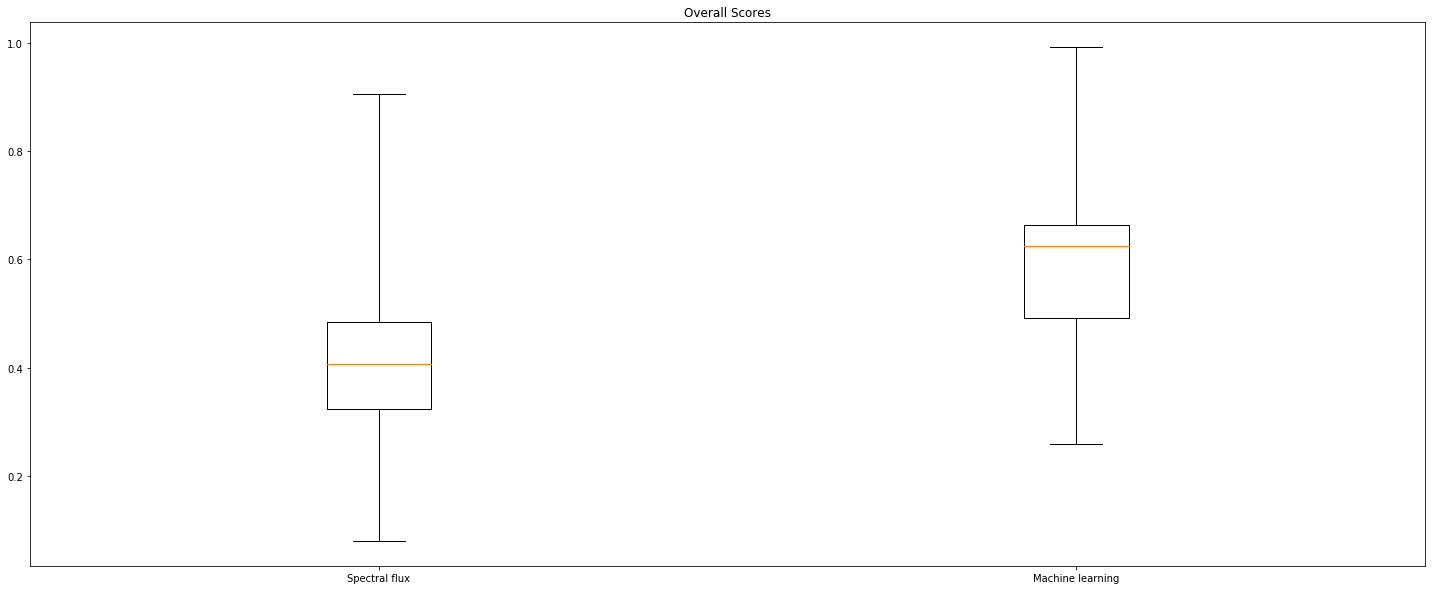

In [ ]:
# Overall scores

plt_array = np.vstack((list(scores_sf.values()), list(scores_ml.values()))).T
plt.figure(figsize=(25,10))
_ = plt.boxplot(plt_array, whis='range')
plt.title('Overall Scores')
_ = plt.xticks([1, 2], ['Spectral flux', 'Machine learning'])

In [ ]:
def split_by_player(scores_dictionary):
    """Split scores by player id

    Parameters
    ----------
    scores_dictionary : dict
        Dictionary of scores keyed by track_id

    Returns
    -------
    player_scores : dict
        Dictionary with player ids as keys and a
        dictionary of scores keyed by track_id as values

    """
    
    player_scores = {}
    player_ids = set()

    for key, value in scores_dictionary.items():
        player_ids.add(key[:2])
    
    player_ids = sorted(player_ids)
    
    for player in player_ids:
        player_scores[player] = {key:value for (key, value) in scores_dictionary.items() if key[:2] == player}

    return player_scores

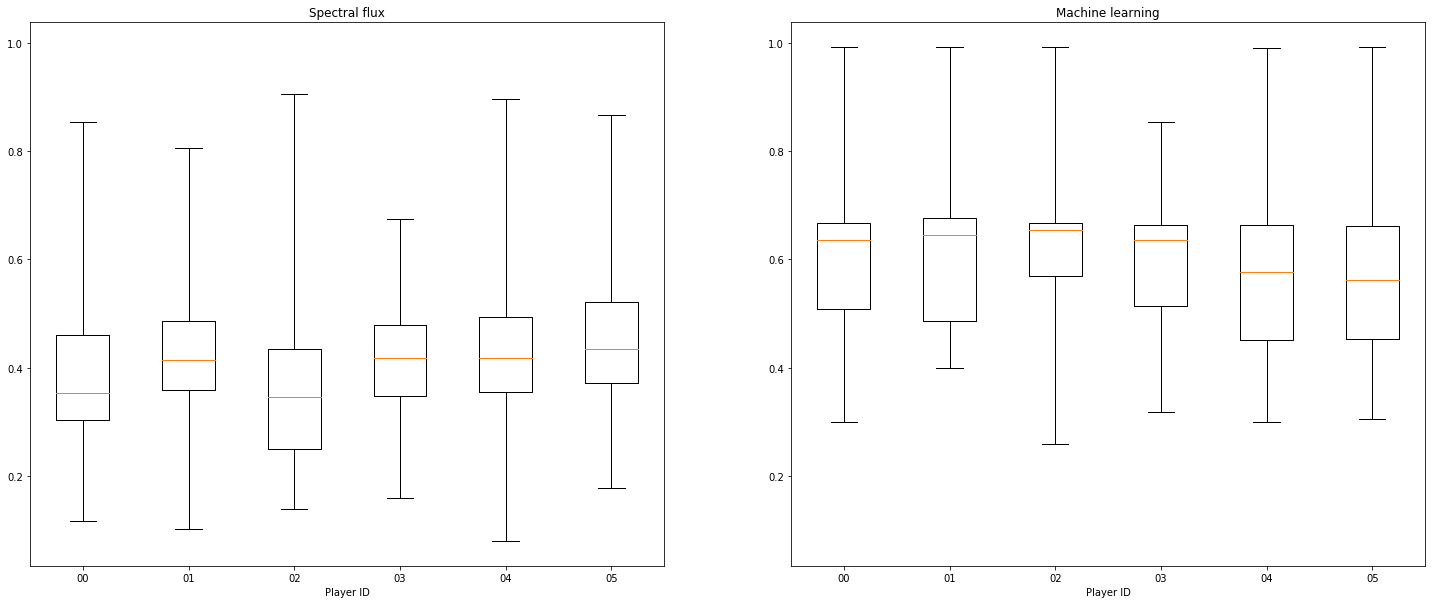

In [ ]:
player_scores_sf = split_by_player(scores_sf)
player_scores_ml = split_by_player(scores_ml)

# Scores by player figure
player_list = list(player_scores_sf.keys())
len_per_player = len(player_scores_sf[player_list[0]].values())
n_player = len(player_list)

player_plt_array_sf = np.zeros((len(player_list), len_per_player))
player_plt_array_ml = np.copy(player_plt_array_sf)

for key, value in player_scores_sf.items():
    score_list = np.array(list(value.values()))
    player_plt_array_sf[int(key),:] = score_list

for key, value in player_scores_ml.items():
    score_list = np.array(list(value.values()))
    player_plt_array_ml[int(key),:] = score_list

player_plt_array_sf = np.swapaxes(player_plt_array_sf, 0, 1)
player_plt_array_ml = np.swapaxes(player_plt_array_ml, 0, 1)
    
plt.figure(figsize=(25,10))
ax1 = plt.subplot(1, 2, 1)
_ = plt.boxplot(player_plt_array_sf, whis='range')
_ = plt.xticks(np.arange(1, n_player + 1), player_list)
_ = plt.title('Spectral flux')
_ = plt.xlabel('Player ID')

plt.subplot(1, 2, 2, sharey=ax1)
_ = plt.boxplot(player_plt_array_ml, whis='range')
_ = plt.xticks(np.arange(1, n_player + 1), player_list)
_ = plt.title('Machine learning')
_ = plt.xlabel('Player ID')


In [ ]:
def split_by_mode(scores_dictionary):
    """Split scores by mode ('solo' or 'comp')

    Parameters
    ----------
    scores_dictionary : dict
        Dictionary of scores keyed by track_id

    Returns
    -------
    mode_scores : dict
        Dictionary with mode as keys and a
        dictionary of scores keyed by track_id as values

    """
    
    mode_scores = {}
    modes = set()

    for key, value in scores_dictionary.items():
        modes.add(key[-8:-4])
    
    for mode in modes:
        mode_scores[mode] = {key:value for (key, value) in scores_dictionary.items() if mode in key}

    return mode_scores

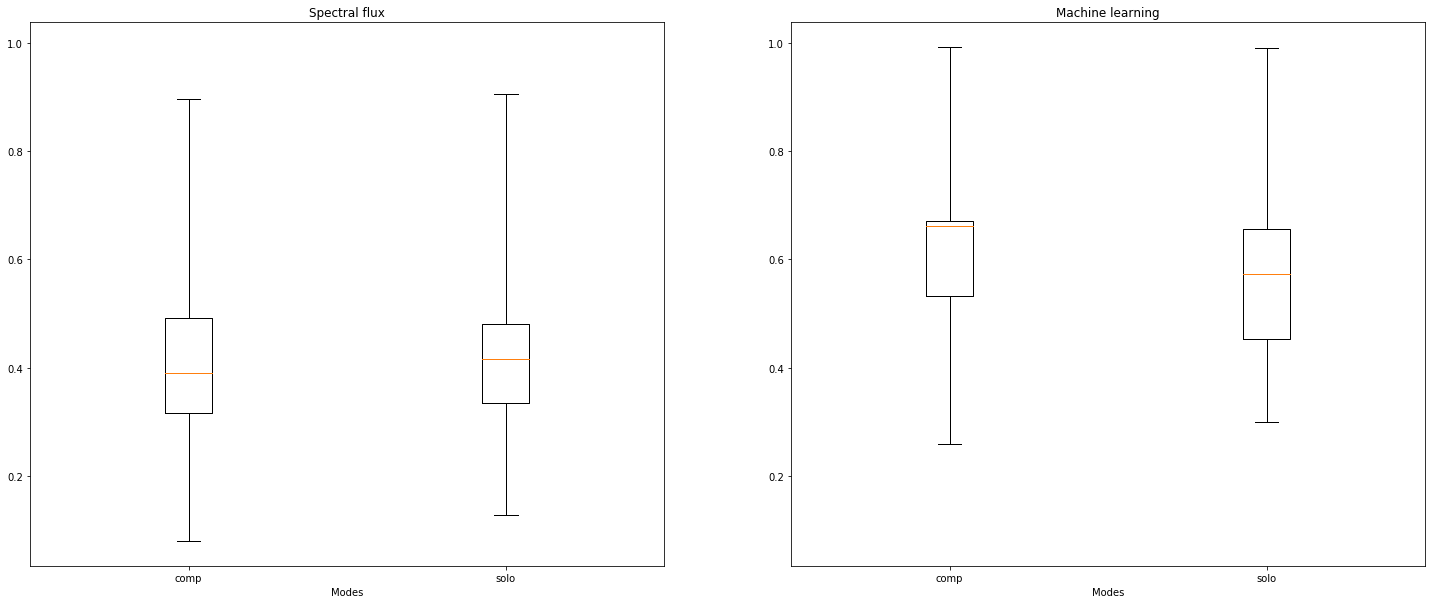

In [ ]:
mode_scores_sf = split_by_mode(scores_sf)
mode_scores_ml = split_by_mode(scores_ml)

# Scores by playing mode figure
mode_list = list(mode_scores_sf.keys())
len_per_mode = len(mode_scores_sf[mode_list[0]].values())
n_mode = len(mode_list)

mode_plt_array_sf = np.zeros((len_per_mode))
mode_plt_array_ml = np.copy(mode_plt_array_sf)

for key, value in mode_scores_sf.items():
    score_list = np.array(list(value.values()), ndmin=2)
    mode_plt_array_sf = np.vstack((mode_plt_array_sf, score_list))

for key, value in mode_scores_ml.items():
    score_list = np.array(list(value.values()), ndmin=2)
    mode_plt_array_ml = np.vstack((mode_plt_array_ml, score_list))

mode_plt_array_sf = mode_plt_array_sf[1::,:]
mode_plt_array_sf = np.swapaxes(mode_plt_array_sf, 0, 1)
mode_plt_array_ml = mode_plt_array_ml[1::,:]
mode_plt_array_ml = np.swapaxes(mode_plt_array_ml, 0, 1)
    
plt.figure(figsize=(25,10))
ax1 = plt.subplot(1, 2, 1)
_ = plt.boxplot(mode_plt_array_sf, whis='range')
_ = plt.xticks(np.arange(1, n_mode + 1), mode_list)
_ = plt.title('Spectral flux')
_ = plt.xlabel('Modes')

plt.subplot(1, 2, 2, sharey=ax1)
_ = plt.boxplot(mode_plt_array_ml, whis='range')
_ = plt.xticks(np.arange(1, n_mode + 1), mode_list)
_ = plt.title('Machine learning')
_ = plt.xlabel('Modes')


In [ ]:
def split_by_style(scores_dictionary):
    """Split scores by style

    Parameters
    ----------
    scores_dictionary : dict
        Dictionary of scores keyed by track_id

    Returns
    -------
    style_scores : dict
        Dictionary with style as keys and a
        dictionary of scores keyed by track_id as values

    """
    
    style_scores = {}
    styles = set()

    for key, value in scores_dictionary.items():
        s = key[3:].split('-')
        styles.add(s[0][:-1])
    
    for style in styles:
        style_scores[style] = {key:value for (key, value) in scores_dictionary.items() if style in key}
    
    return style_scores

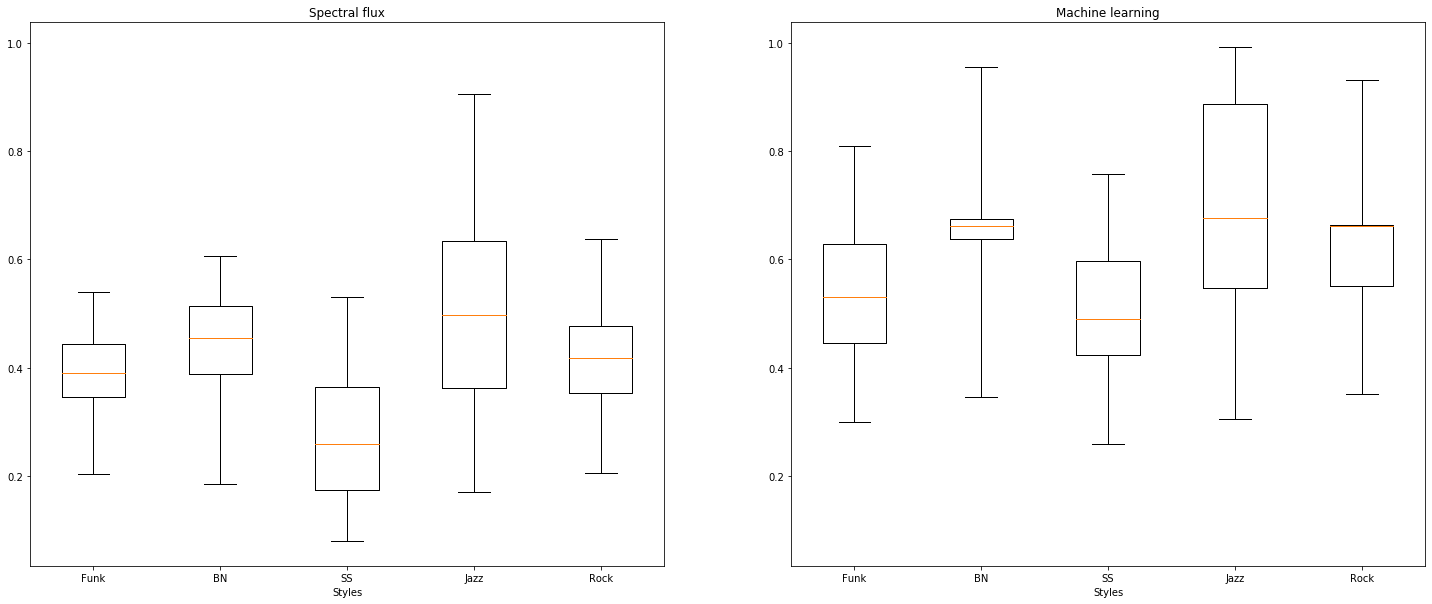

In [ ]:
style_scores_sf = split_by_style(scores_sf)
style_scores_ml = split_by_style(scores_ml)

# Scores by genre/style figure
style_list = list(style_scores_sf.keys())
len_per_style = len(style_scores_sf[style_list[0]].values())
n_style = len(style_list)

style_plt_array_sf = np.zeros((len_per_style))
style_plt_array_ml = np.copy(style_plt_array_sf)

for key, value in style_scores_sf.items():
    score_list = np.array(list(value.values()), ndmin=2)
    style_plt_array_sf = np.vstack((style_plt_array_sf, score_list))

for key, value in style_scores_ml.items():
    score_list = np.array(list(value.values()), ndmin=2)
    style_plt_array_ml = np.vstack((style_plt_array_ml, score_list))

style_plt_array_sf = style_plt_array_sf[1::,:]
style_plt_array_sf = np.swapaxes(style_plt_array_sf, 0, 1)
style_plt_array_ml = style_plt_array_ml[1::,:]
style_plt_array_ml = np.swapaxes(style_plt_array_ml, 0, 1)
    
plt.figure(figsize=(25,10))
ax1 = plt.subplot(1, 2, 1)
_ = plt.boxplot(style_plt_array_sf, whis='range')
_ = plt.xticks(np.arange(1, n_style + 1), style_list)
_ = plt.title('Spectral flux')
_ = plt.xlabel('Styles')

plt.subplot(1, 2, 2, sharey=ax1)
_ = plt.boxplot(style_plt_array_ml, whis='range')
_ = plt.xticks(np.arange(1, n_style + 1), style_list)
_ = plt.title('Machine learning')
_ = plt.xlabel('Styles')


In [ ]:
def get_tempo_vs_score(scores_dictionary):
    """Get score values as a function of tempo

    Parameters
    ----------
    scores_dictionary : dict
        Dictionary of scores keyed by track_id

    Returns
    -------
    tempo : np.array
        Array of tempo values with the same number of elements as scores_dictionary
    scores : np.array
        Array of scores with the same number of elements as scores_dictionary
    """
    tempos = []
    scores = []
    
    def get_tempo(key:str):       
        return key.split('-')[1]

    for key, value in scores_dictionary.items():
        tempo_split = lambda key : key.split('-')[1]
        tempos.append(tempo_split(key))
        scores.append(value)
    
    tempos = [int(tempo) for tempo in tempos]
    zipped_list = zip(tempos, scores)
    sorted_pairs = sorted(zipped_list)
    tuples = zip(*sorted_pairs)
    tempos_sorted, scores_sorted = [ list(tup) for tup in  tuples]
    tempos_sorted = [str(tempo) for tempo in tempos_sorted]
    
    return tempos_sorted, scores_sorted

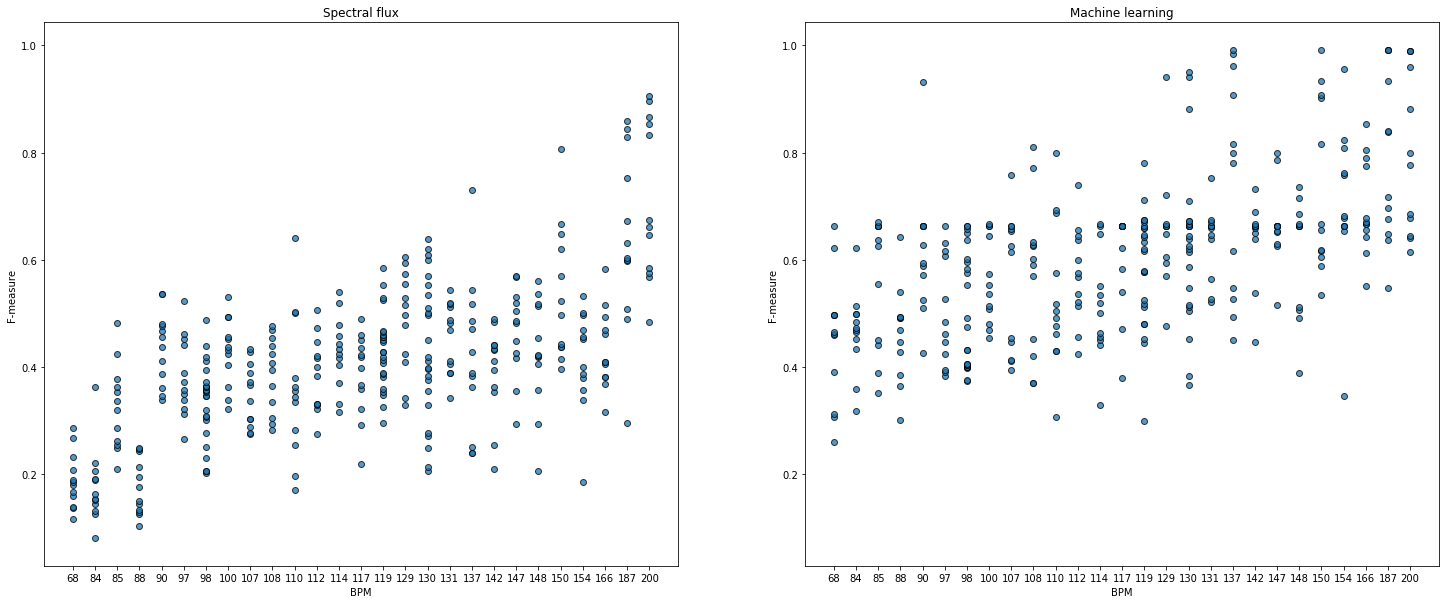

In [ ]:
tempo_sf, score_by_tempo_sf = get_tempo_vs_score(scores_sf)
tempo_ml, score_by_tempo_ml = get_tempo_vs_score(scores_ml)

# Scores by tempo figure
plt.figure(figsize=(25,10))
ax1 = plt.subplot(1, 2, 1)
_ = plt.scatter(tempo_sf, score_by_tempo_sf, edgecolors='black', linewidths=1, alpha=0.75)
_ = plt.title('Spectral flux')
_ = plt.xlabel('BPM')
_ = plt.ylabel('F-measure')

plt.subplot(1, 2, 2, sharey=ax1)
_ = plt.scatter(tempo_ml, score_by_tempo_ml, edgecolors='black', linewidths=1, alpha=0.75)
_ = plt.title('Machine learning')
_ = plt.xlabel('BPM')
_ = plt.ylabel('F-measure')


In [ ]:
def get_truth(file_dir):
    '''Get truth data from text file.
    
    Parameters
    ----------
    file_dir : str
        File name (*.txt) and path to ground truth

    Returns
    -------
    times : np.array
        stimes of each frequency
    frequencies: np.array
        Estimated frequency at corresponding time
        
    '''
    
    times = np.array([])
    frequencies = np.array([])
    data = np.loadtxt(file_dir)
    for i in data:
        times = np.append(times,i[0])
        frequencies = np.append(frequencies,i[1])
    
    return times, frequencies

In [ ]:
file = "003"
time_test, freq_test = get_truth("pitch_data/" + file + ".txt")
pc2, sr = librosa.load("pitch_audio/" + file + ".wav")
pc = pitch_contour(time_test,freq_test, fs=sr)
a1 = IPython.display.Audio(pc,rate=sr)
a2 = IPython.display.Audio(pc2,rate=sr)

print("Real Audio:")
IPython.display.display(a2)
print("Synthesized Ground Truth Pitch Contour:")
IPython.display.display(a1)

Real Audio:


Synthesized Ground Truth Pitch Contour:


## 3. Pitch Estimation

Estimate pitch with the following methods: 
- Spectrogram argmax for each m in the STFT matgnitude spectrum
- YIN
- Crepe pitch tracking algorithm

Crepe Documentation: https://github.com/marl/crepe

In [ ]:
def estimate_pitch(audio_path, pc_type, N=2048, voicing_threshold=0.7):
    
    """Estimate the pitch of an audio_path using one of the 4 above algorithm, and using a threshold
       on the voicing confidence to determine when frames are unvoiced.
    
    Parameters
    ----------
    audio_path : str
        Path to input audio file
    N : int
        frame length, if applicable
    voicing_threshold : float
        Threshold on the voicing to determine which frames are unvoiced.
    type : str
        one of 'argmax', 'yin', or 'crepe' 
    
    Returns
    -------
    times : np.ndarray shape=(T,)
        Numpy array of time stamps of length T in seconds
    frequencies : np.ndarray shape=(T,)
        Numpy array of predicted frequency values in Hz

    """
    
    ## Different pitch estimation functions
    def pitch_argmax(signal):
        time = []
        f0 =[]
        
        S = np.abs(librosa.stft(y=signal, n_fft=N))
        freqs = librosa.fft_frequencies(sr)
        harms = [1, 2, 3, 4]
        weights = [1.0, 0.5, 0.33, 0.25]
        hop_size = N // 4
        
        S_sal = librosa.salience(S, freqs, harms, weights, fill_value=0)
        S_sal[S_sal < voicing_threshold] = 0
        n_frames = S_sal.shape[1]
        
        for frame in range(n_frames):
            bin_num = np.argmax(S_sal[:,frame])
            freq_num = bin_num * sr / N
            samp_num = frame * hop_size
            time.append(samp_num / sr)
            f0.append(freq_num)

        return time, f0
    
    def pitch_yin(signal):
        time = []
        f0 =[]
        frame_length=2048
        hop_size = frame_length // 4
        
        est_f0, voiced_flag, voiced_probs = librosa.pyin(y=signal, frame_length=frame_length, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
        n_frames = len(est_f0)
        
        for frame in range(n_frames):
            samp_num = frame * hop_size
            time.append(samp_num / sr)
            
            if voiced_flag[frame]:
                f0.append(est_f0[frame])
            else:
                f0.append(0)
        
        return time, f0
    
    def pitch_crepe(signal):
        time, f0, confidence, activation = crepe.predict(signal, sr=sr, viterbi=True)
        return time, f0
    
    ## Switch case dictionary
    switch = {
        'argmax': pitch_argmax,
        'yin': pitch_yin,
        'crepe': pitch_crepe
    }
    
    ## Process
    audio, sr = librosa.load(audio_path, mono=True)
    length = len(audio)

    switcher = lambda pitch_method : switch.get(pitch_method)(audio)
    times, frequencies = switcher(pc_type)
    
    return np.array(times), np.array(frequencies)

## 4. Pitch Tracking Results

Goal:

1. Find the algorithn with the overall best accuracy and the algorithm with the overall worst accuracy.
2. Find the audio file that has the best accuracy and the audio file with the worst accuracy.

In [ ]:
#Evaluate results

pitch_ref_dir = './pitch_data/'
pitch_audio_dir = './pitch_audio/'

file_list = [filename[:-4] for filename in os.listdir(pitch_ref_dir)]
pitch_estimate_type = ['argmax', 'yin', 'crepe']

# evaluation_dict_schema = {
#     filename1: {
#         'argmax': accuracy,
#         'yin': accuracy,
#         'crepe': accuracy
#     },
#     filename2: {
#         'argmax': accuracy,
#         'yin': accuracy,
#         'crepe': accuracy
#     }
# }

evaluation_dict = {}
for file in file_list:
    type_dict = {}
    ref_name = f'{file}.txt'
    audio_name = f'{file}.wav'

    ref_file = open(pitch_ref_dir + ref_name)
    ref_time, ref_freq = zip(*[map(float,line.split()) for line in ref_file])
    ref_time = np.array(list(ref_time))
    ref_freq = np.array(list(ref_freq))
    
    for pe_type in pitch_estimate_type:
        est_time, est_freq = estimate_pitch(f'{pitch_audio_dir}{audio_name}', pc_type=pe_type)
        
        type_eval = evaluate(ref_time=ref_time, ref_freq=ref_freq, est_time=est_time, est_freq=est_freq)
        type_dict[pe_type] = type_eval
    
    evaluation_dict[file] = type_dict

evaluation_dict

64/64 [==============================] - 16s 255ms/step


{'000': {'argmax': OrderedDict([('Voicing Recall', 0.9996739484838605),
               ('Voicing False Alarm', 1.0),
               ('Raw Pitch Accuracy', 0.16041734594065862),
               ('Raw Chroma Accuracy', 0.4812520378219759),
               ('Overall Accuracy', 0.13402342685916643)]),
  'yin': OrderedDict([('Voicing Recall', 0.915226605803717),
               ('Voicing False Alarm', 0.8162251655629139),
               ('Raw Pitch Accuracy', 0.7766547114444082),
               ('Raw Chroma Accuracy', 0.883273557222041),
               ('Overall Accuracy', 0.6791065104876055)]),
  'crepe': OrderedDict([('Voicing Recall', 1.0),
               ('Voicing False Alarm', 1.0),
               ('Raw Pitch Accuracy', 0.6387349201173785),
               ('Raw Chroma Accuracy', 0.86957939354418),
               ('Overall Accuracy', 0.5336420593843639)])},
 '001': {'argmax': OrderedDict([('Voicing Recall', 0.9996044303797469),
               ('Voicing False Alarm', 0.11555555555555555),
 

In [ ]:
file_num = len(file_list)
file_acc = {}
algo_acc = {
    'argmax': 0,
    'yin': 0,
    'crepe': 0
}

for file in file_list:
    file_acc[file] = 0
    for pe_type in pitch_estimate_type:
        algo_acc[pe_type] += evaluation_dict[file][pe_type]['Overall Accuracy']
        file_acc[file] += evaluation_dict[file][pe_type]['Overall Accuracy']
    
algo_best = max(algo_acc, key=algo_acc.get)
algo_worst = min(algo_acc, key=algo_acc.get)

file_best = max(file_acc, key=file_acc.get)
file_worst = min(file_acc, key=file_acc.get)

print(f'Algorithm with overall best accuracy: {algo_best}')
print(f'Algorithm with overall worst accuracy: {algo_worst}')
print(f'Audio that has best accuracy: {file_best}.wav')
print(f'Audio that has worst accuracy: {file_worst}.wav')

Algorithm with overall best accuracy: crepe
Algorithm with overall worst accuracy: argmax
Audio that has best accuracy: 003.wav
Audio that has worst accuracy: 000.wav


## 5. Analysis

Questions to Answer:
1. Compare algorithm performance of beat and pitch tracking.
2. Problems existing in the tasks of beat and pitch tracking?



### Plot Pitch Contour with Estimated Beats
Plot pitch contour overlayed with vertical lines indicating estimatesd beat positions

51/51 [==============================] - 13s 253ms/step
001.wav - Pitch Contour + Estimated Beat:


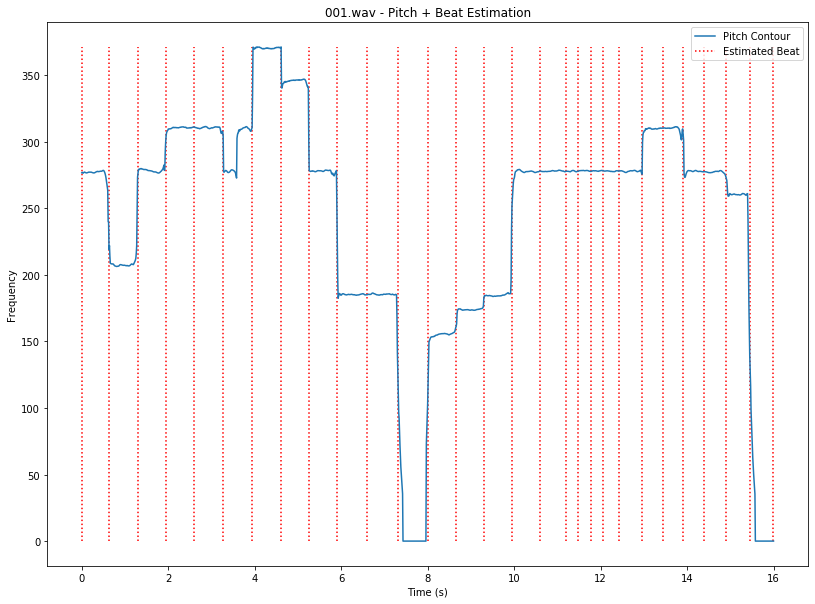

In [ ]:
file = '001'
audio_path = f'./pitch_audio/{file}.wav'
onset_type = 'machine_learning'
pc_type = 'crepe'

_, sr = librosa.load(audio_path)

est_beats = estimate_beats(audio_path, onset_type)
est_time, est_freq = estimate_pitch(audio_path, pc_type)

## Click track + Pitch contour
pc = pitch_contour(est_time, est_freq, fs=sr)
pc_length = pc.shape[0]
click_track = librosa.clicks(times=est_beats, sr=sr)
click_track = click_track[:pc.shape[0]]
a1 = IPython.display.Audio(pc+click_track, rate=sr)

## Plot
plt.figure(figsize=(30,10))
ax1 = plt.subplot(1, 2, 1)
_ = plt.plot(est_time, est_freq, label='Pitch Contour')
_ = plt.vlines(est_beats, 0, np.amax(est_freq), color='r', linestyle='dotted', label='Estimated Beat')
_ = plt.legend(loc="upper right")
_ = plt.title(f'{file}.wav - Pitch + Beat Estimation')
_ = plt.xlabel('Time (s)')
_ = plt.ylabel('Frequency')

print(f'{file}.wav - Pitch Contour + Estimated Beat:')
IPython.display.display(a1)

38/38 [==============================] - 10s 259ms/step
002.wav - Pitch Contour + Estimated Beat:


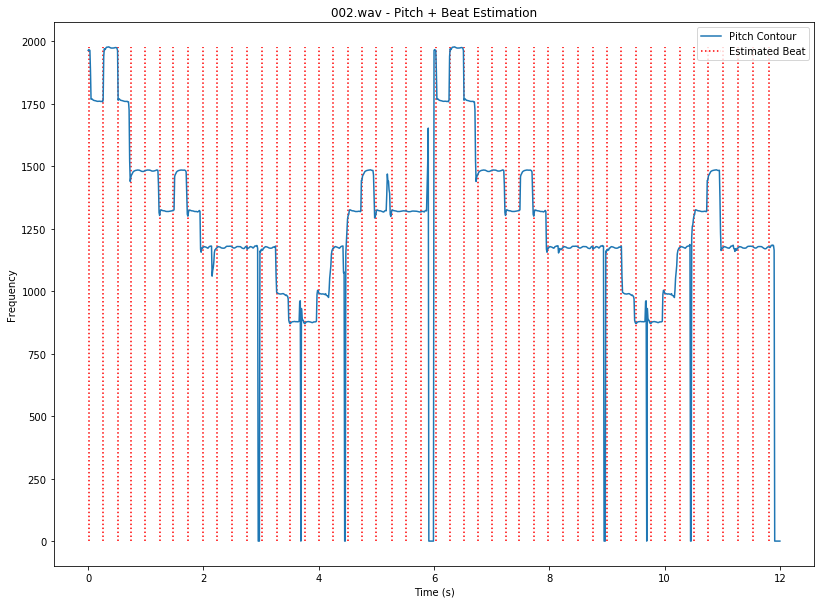

In [ ]:
file = '002'
audio_path = f'./pitch_audio/{file}.wav'
onset_type = 'machine_learning'
pc_type = 'crepe'

_, sr = librosa.load(audio_path)

est_beats = estimate_beats(audio_path, onset_type)
est_time, est_freq = estimate_pitch(audio_path, pc_type)

## Click track + Pitch contour
pc = pitch_contour(est_time, est_freq, fs=sr)
pc_length = pc.shape[0]
click_track = librosa.clicks(times=est_beats, sr=sr)
click_track = np.concatenate((click_track, np.zeros(pc.shape[0] - click_track.shape[0])))
a1 = IPython.display.Audio(pc+click_track, rate=sr)

## Plot
plt.figure(figsize=(30,10))
ax1 = plt.subplot(1, 2, 1)
_ = plt.plot(est_time, est_freq, label='Pitch Contour')
_ = plt.vlines(est_beats, 0, np.amax(est_freq), color='r', linestyle='dotted', label='Estimated Beat')
_ = plt.legend(loc="upper right")
_ = plt.title(f'{file}.wav - Pitch + Beat Estimation')
_ = plt.xlabel('Time (s)')
_ = plt.ylabel('Frequency')

print(f'{file}.wav - Pitch Contour + Estimated Beat:')
IPython.display.display(a1)

76/76 [==============================] - 20s 262ms/step
003.wav - Pitch Contour + Estimated Beat:


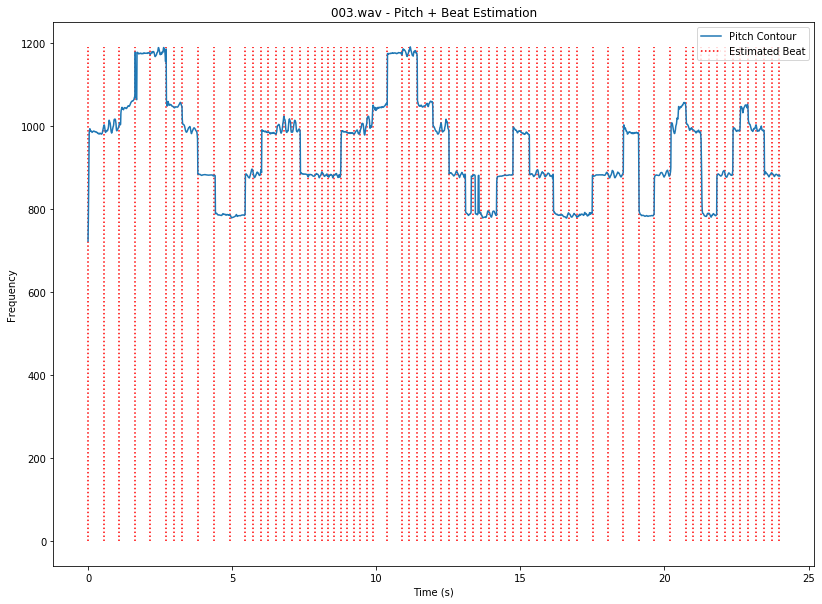

In [ ]:
file = '003'
audio_path = f'./pitch_audio/{file}.wav'
onset_type = 'machine_learning'
pc_type = 'crepe'

_, sr = librosa.load(audio_path)

est_beats = estimate_beats(audio_path, onset_type)
est_time, est_freq = estimate_pitch(audio_path, pc_type)

## Click track + Pitch contour
pc = pitch_contour(est_time, est_freq, fs=sr)
pc_length = pc.shape[0]
click_track = librosa.clicks(times=est_beats, sr=sr)
click_track = click_track[:pc.shape[0]]
a1 = IPython.display.Audio(pc+click_track, rate=sr)

## Plot
plt.figure(figsize=(30,10))
ax1 = plt.subplot(1, 2, 1)
_ = plt.plot(est_time, est_freq, label='Pitch Contour')
_ = plt.vlines(est_beats, 0, np.amax(est_freq), color='r', linestyle='dotted', label='Estimated Beat')
_ = plt.legend(loc="upper right")
_ = plt.title(f'{file}.wav - Pitch + Beat Estimation')
_ = plt.xlabel('Time (s)')
_ = plt.ylabel('Frequency')

print(f'{file}.wav - Pitch Contour + Estimated Beat:')
IPython.display.display(a1)

004.wav - Pitch Contour + Estimated Beat:


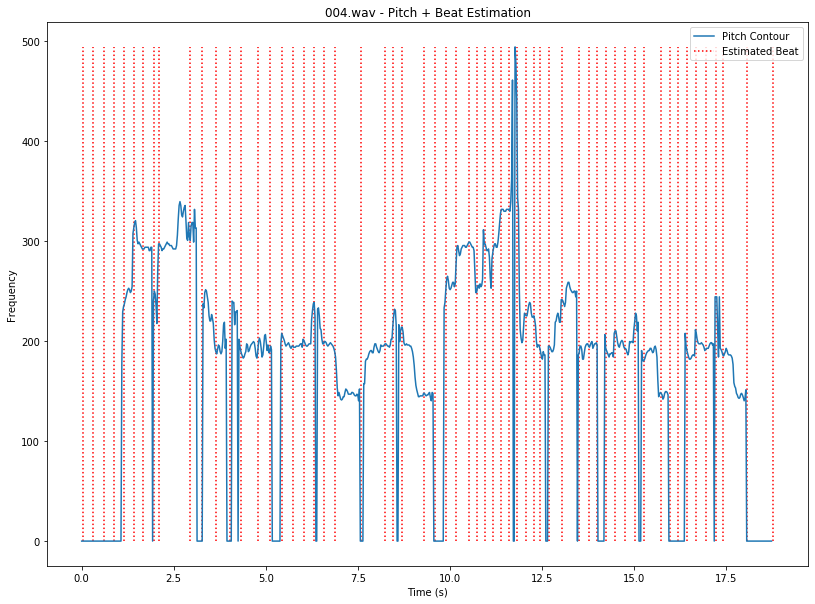

In [ ]:
file = '004'
audio_path = f'./pitch_audio/{file}.wav'
onset_type = 'spectral_flux'
pc_type = 'yin'

_, sr = librosa.load(audio_path)

est_beats = estimate_beats(audio_path, onset_type)
est_time, est_freq = estimate_pitch(audio_path, pc_type)

## Click track + Pitch contour
pc = pitch_contour(est_time, est_freq, fs=sr)
pc_length = pc.shape[0]
click_track = librosa.clicks(times=est_beats, sr=sr)
click_track = click_track[:pc.shape[0]]
a1 = IPython.display.Audio(pc+click_track, rate=sr)

## Plot
plt.figure(figsize=(30,10))
ax1 = plt.subplot(1, 2, 1)
_ = plt.plot(est_time, est_freq, label='Pitch Contour')
_ = plt.vlines(est_beats, 0, np.amax(est_freq), color='r', linestyle='dotted', label='Estimated Beat')
_ = plt.legend(loc="upper right")
_ = plt.title(f'{file}.wav - Pitch + Beat Estimation')
_ = plt.xlabel('Time (s)')
_ = plt.ylabel('Frequency')

print(f'{file}.wav - Pitch Contour + Estimated Beat:')
IPython.display.display(a1)

31/31 [==============================] - 8s 248ms/step
006.wav - Pitch Contour + Estimated Beat:


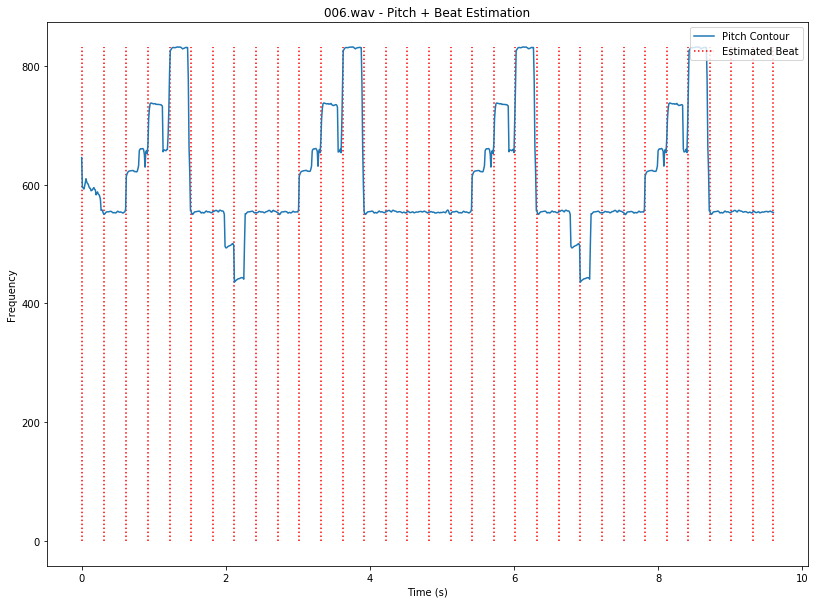

In [ ]:
file = '006'
audio_path = f'./pitch_audio/{file}.wav'
onset_type = 'machine_learning'
pc_type = 'crepe'

_, sr = librosa.load(audio_path)

est_beats = estimate_beats(audio_path, onset_type)
est_time, est_freq = estimate_pitch(audio_path, pc_type)

## Click track + Pitch contour
pc = pitch_contour(est_time, est_freq, fs=sr)
pc_length = pc.shape[0]
click_track = librosa.clicks(times=est_beats, sr=sr)
click_track = click_track[:pc.shape[0]]
a1 = IPython.display.Audio(pc+click_track, rate=sr)

## Plot
plt.figure(figsize=(30,10))
ax1 = plt.subplot(1, 2, 1)
_ = plt.plot(est_time, est_freq, label='Pitch Contour')
_ = plt.vlines(est_beats, 0, np.amax(est_freq), color='r', linestyle='dotted', label='Estimated Beat')
_ = plt.legend(loc="upper right")
_ = plt.title(f'{file}.wav - Pitch + Beat Estimation')
_ = plt.xlabel('Time (s)')
_ = plt.ylabel('Frequency')

print(f'{file}.wav - Pitch Contour + Estimated Beat:')
IPython.display.display(a1)

007.wav - Pitch Contour + Estimated Beat:


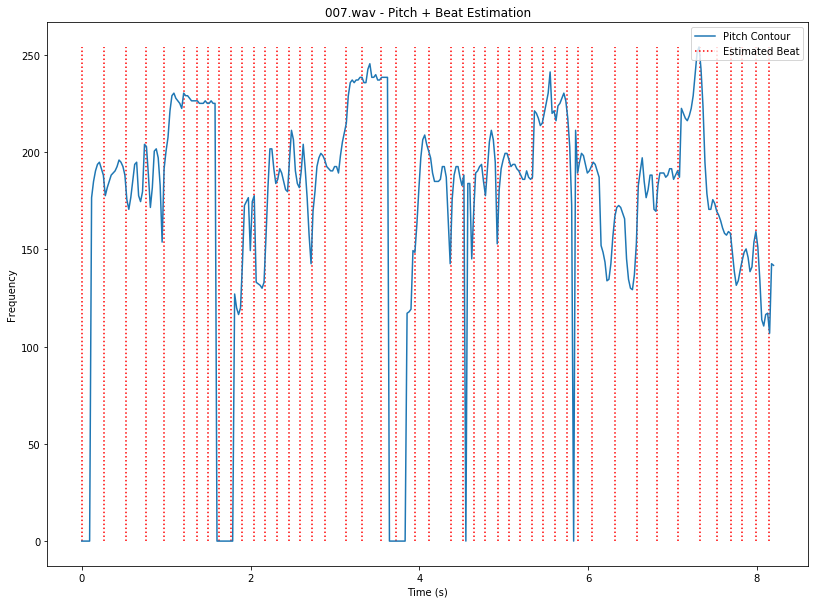

In [ ]:
file = '007'
audio_path = f'./pitch_audio/{file}.wav'
onset_type = 'machine_learning'
pc_type = 'yin'

_, sr = librosa.load(audio_path)

est_beats = estimate_beats(audio_path, onset_type)
est_time, est_freq = estimate_pitch(audio_path, pc_type)

## Click track + Pitch contour
pc = pitch_contour(est_time, est_freq, fs=sr)
pc_length = pc.shape[0]
click_track = librosa.clicks(times=est_beats, sr=sr)
click_track = click_track[:pc.shape[0]]
a1 = IPython.display.Audio(pc+click_track, rate=sr)

## Plot
plt.figure(figsize=(30,10))
ax1 = plt.subplot(1, 2, 1)
_ = plt.plot(est_time, est_freq, label='Pitch Contour')
_ = plt.vlines(est_beats, 0, np.amax(est_freq), color='r', linestyle='dotted', label='Estimated Beat')
_ = plt.legend(loc="upper right")
_ = plt.title(f'{file}.wav - Pitch + Beat Estimation')
_ = plt.xlabel('Time (s)')
_ = plt.ylabel('Frequency')

print(f'{file}.wav - Pitch Contour + Estimated Beat:')
IPython.display.display(a1)

### Overview
Looking at the analysis on all of the audio above, the pitch tracking algorithms did really well while the beat tracking did an overall pretty good job with some tiny quirks.

---
### Problems

##### Pitch Tracking
For pitch estimations, most of the time the crepe machine learning algorithm performed the best, the times it struggled a bit is when there were a lot of vibrato or tremelo in the track. Yin did substantially well when estimate pitches for melodies sang by singers but was slightly worse than crepe's algorithm on other tracks. Argmax were correct most of the time but have quite a lot of 'glitches' when listening to the pitch contour.

##### Beat Tracking
Beat tracking on the other hand gave some mixed result. I find that when the beat of the track is steady and when the note doesn't linger on for too long, it did a pretty good job at predicting the beat for each track. However, if there sounds like there's a little bit of swing or when it's on human voices, it seems to miss completely.

---
### Difference
Fundimentally I think pitch tracking and beat estimation are different tasks. While they are highly related in their application as when instruments or sounds start playing, there usually is an onset and and a pitch. However, the methods used to get the results are different as beat tracking tracks the energy in a given period of time while pitch tracking tracks the energy of an fundemental frequency and its harmonics in a given period of time.

---
### Suprises
The pitch tracking methods didn't gave me too much suprise. The only suprise is that machine learning methods does not always give the most accurate result.\
The beat tracking methods on the other hand gave some interesting results. On some tracks the estimated beats were not consistant, however, it switches between the actual beat of the track and the 1/8th or 1/16th note of the beat. I am not certain as to why this happens, but I did observe this behavior.
